In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Unzip your dataset (adjust the path if your zip is elsewhere)
!unzip -q "/content/drive/MyDrive/GERALD_subset.zip" -d "/content/"

print("Done! Dataset extracted to /content/GERALD_subset")


Mounted at /content/drive
Done! Dataset extracted to /content/GERALD_subset


In [2]:
from pathlib import Path
import xml.etree.ElementTree as ET
import cv2

# ROOT DIRECTORIES
root_dataset_dir = Path("/content/GERALD_subset/")
images_directory = root_dataset_dir / "images"
annotations_directory = root_dataset_dir / "annotations"

# DIAGNOSTIC COUNTERS
xml_file_count = 0
label_file_count = 0
total_detected_objects = 0
skipped_file_list = []
sample_label_outputs = []

print(f"Root directory: {root_dataset_dir}")
print(f"Images directory: {images_directory} (exists: {images_directory.exists()})")
print(f"Annotations directory: {annotations_directory} (exists: {annotations_directory.exists()})")
print(f"XML files found: {len(list(annotations_directory.glob('*.xml')))}")
print(f"Image files found: {len(list(images_directory.glob('*.jpg')))}")
print("=" * 60)

# PROCESS EACH XML FILE
for xml_annotation_file in annotations_directory.glob("*.xml"):
    xml_file_count += 1

    try:
        # LOAD XML
        try:
            xml_tree = ET.parse(xml_annotation_file)
            xml_root = xml_tree.getroot()
        except Exception as parse_err:
            print(f"Failed to parse XML: {xml_annotation_file.name} ({parse_err})")
            skipped_file_list.append(xml_annotation_file.name)
            continue

        # EXTRACT IMAGE NAME
        image_filename = xml_root.find("filename").text
        image_path = images_directory / image_filename

        # VERIFY IMAGE EXISTS
        if not image_path.exists():
            print(f"Image not found: {image_filename}")
            skipped_file_list.append(image_filename)
            continue

        # LOAD IMAGE
        try:
            image = cv2.imread(str(image_path))
        except Exception as read_err:
            print(f"Error reading image {image_filename}: {read_err}")
            skipped_file_list.append(image_filename)
            continue

        if image is None:
            print(f"cv2 failed to load image: {image_filename}")
            skipped_file_list.append(image_filename)
            continue

        image_height, image_width = image.shape[:2]

        yolo_lines = []
        object_count = 0

        # PROCESS EACH OBJECT
        for detected_object in xml_root.findall("object"):

            class_name = detected_object.find("name").text.strip()
            class_id = 0 if class_name == "main_signal" else 1

            bounding_box = detected_object.find("bndbox")

            # RAW COORDINATES
            x_min = float(bounding_box.find("xmin").text)
            y_min = float(bounding_box.find("ymin").text)
            x_max = float(bounding_box.find("xmax").text)
            y_max = float(bounding_box.find("ymax").text)

            # YOLO NORMALIZATION
            center_x = ((x_min + x_max) / 2) / image_width
            center_y = ((y_min + y_max) / 2) / image_height
            box_width = (x_max - x_min) / image_width
            box_height = (y_max - y_min) / image_height

            # VALIDATION CHECK
            if not (0 <= center_x <= 1 and 0 <= center_y <= 1 and
                    0 <= box_width <= 1 and 0 <= box_height <= 1):
                print(f"Invalid coordinates in {image_filename}: "
                      f"cx={center_x}, cy={center_y}, w={box_width}, h={box_height}")

            yolo_lines.append(
                f"{class_id} {center_x:.6f} {center_y:.6f} {box_width:.6f} {box_height:.6f}"
            )

            object_count += 1
            total_detected_objects += 1

        # SAVE YOLO LABEL FILE
        label_output_file = images_directory / (xml_annotation_file.stem + ".txt")
        try:
            with open(label_output_file, "w") as label_file:
                label_file.write("\n".join(yolo_lines))
        except Exception as write_err:
            print(f"Failed to write label file {label_output_file.name}: {write_err}")
            skipped_file_list.append(xml_annotation_file.name)
            continue

        label_file_count += 1

        # SAVE SAMPLE OUTPUTS FOR INSPECTION
        if len(sample_label_outputs) < 3:
            sample_label_outputs.append({
                'xml_file': xml_annotation_file.name,
                'image_file': image_filename,
                'label_file': label_output_file.name,
                'objects_detected': object_count,
                'image_size': f"{image_width}x{image_height}",
                'sample_label': yolo_lines[0] if yolo_lines else "EMPTY"
            })

    except Exception as general_err:
        print(f"Error processing {xml_annotation_file.name}: {general_err}")
        skipped_file_list.append(xml_annotation_file.name)

# ---------------- SUMMARY OUTPUT ---------------- #

print("\n" + "=" * 60)
print("SUMMARY:")
print(f"XML files processed: {xml_file_count}")
print(f"Label files created: {label_file_count}")
print(f"Total objects annotated: {total_detected_objects}")
print(f"Skipped files: {len(skipped_file_list)}")
print(f"Average objects per image: "
      f"{total_detected_objects / label_file_count if label_file_count else 0:.2f}")

print("\n SAMPLE OUTPUTS:")
for i, sample in enumerate(sample_label_outputs, 1):
    print(f"\nSample {i}:")
    print(f"XML: {sample['xml_file']}")
    print(f"Image: {sample['image_file']} ({sample['image_size']})")
    print(f"Label File: {sample['label_file']}")
    print(f"Objects: {sample['objects_detected']}")
    print(f"Example YOLO Line: {sample['sample_label']}")

if skipped_file_list:
    print(f"\nSKIPPED {len(skipped_file_list)} FILES:")
    for f in skipped_file_list[:5]:
        print(f"   - {f}")
    if len(skipped_file_list) > 5:
        print(f"... and {len(skipped_file_list) - 5} more")

# VERIFICATION OF LABEL FILES
print("\nVERIFICATION:")
label_files_list = list(images_directory.glob("*.txt"))
print(f".txt files in images folder: {len(label_files_list)}")
if label_files_list:
    print(f"First 3 label files: {[f.name for f in label_files_list[:3]]}")


Root directory: /content/GERALD_subset
Images directory: /content/GERALD_subset/images (exists: True)
Annotations directory: /content/GERALD_subset/annotations (exists: True)
XML files found: 1967
Image files found: 1967

SUMMARY:
XML files processed: 1967
Label files created: 1967
Total objects annotated: 3942
Skipped files: 0
Average objects per image: 2.00

 SAMPLE OUTPUTS:

Sample 1:
XML: Rheydt-Aachen.mp4#t=1834.766667.xml
Image: Rheydt-Aachen.mp4#t=1834.766667.jpg (1920x1080)
Label File: Rheydt-Aachen.mp4#t=1834.766667.txt
Objects: 1
Example YOLO Line: 0 0.738802 0.290741 0.057813 0.148148

Sample 2:
XML: K%C3%B6ln_Wuppertal.mp4#t=340.633333.xml
Image: K%C3%B6ln_Wuppertal.mp4#t=340.633333.jpg (1920x1080)
Label File: K%C3%B6ln_Wuppertal.mp4#t=340.633333.txt
Objects: 3
Example YOLO Line: 0 0.483854 0.493056 0.008333 0.037963

Sample 3:
XML: Aachen_Koeln_Nippes.mp4#t=2818.633333.xml
Image: Aachen_Koeln_Nippes.mp4#t=2818.633333.jpg (1280x720)
Label File: Aachen_Koeln_Nippes.mp4#t=281

In [3]:
#Class Distribution Analysis

import xml.etree.ElementTree as ET
from collections import Counter
from pathlib import Path

annotations_dir = Path("/content/GERALD_subset/annotations")
class_list = []

for xml_file in annotations_dir.glob("*.xml"):
    try:
        root = ET.parse(xml_file).getroot()
        for obj in root.findall("object"):
            class_list.append(obj.find("name").text.strip())
    except:
        pass

print("Class Distribution:")
print(Counter(class_list))


Class Distribution:
Counter({'main_signal': 2551, 'distant_signal': 1391})


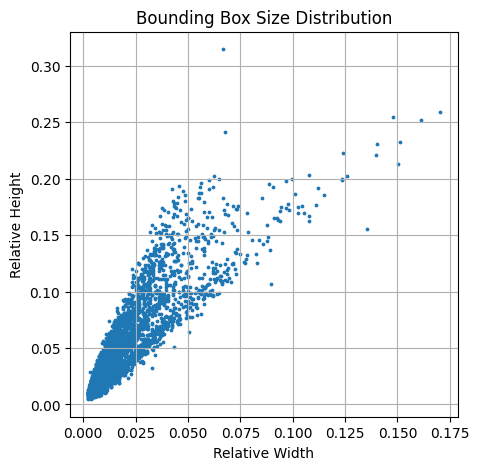

In [4]:
#Bounding Box Size Distribution

import matplotlib.pyplot as plt

box_widths = []
box_heights = []

for xml_file in annotations_dir.glob("*.xml"):
    try:
        root = ET.parse(xml_file).getroot()
        img_w = int(root.find("size/width").text)
        img_h = int(root.find("size/height").text)

        for obj in root.findall("object"):
            bb = obj.find("bndbox")
            xmin = float(bb.find("xmin").text)
            ymin = float(bb.find("ymin").text)
            xmax = float(bb.find("xmax").text)
            ymax = float(bb.find("ymax").text)

            box_widths.append((xmax - xmin) / img_w)
            box_heights.append((ymax - ymin) / img_h)
    except:
        pass

plt.figure(figsize=(5,5))
plt.scatter(box_widths, box_heights, s=3)
plt.xlabel("Relative Width")
plt.ylabel("Relative Height")
plt.title("Bounding Box Size Distribution")
plt.grid(True)
plt.show()


In [5]:
from pathlib import Path
import shutil
import xml.etree.ElementTree as ET
from collections import defaultdict
import random

# Reproducibility
random.seed(42)

# Directories (consistent with first script naming)
root_dataset_dir = Path("/content/GERALD_subset")
images_directory = root_dataset_dir / "images"
annotations_directory = root_dataset_dir / "annotations"

# Train/Val output directories
train_output_dir = root_dataset_dir / "train"
validation_output_dir = root_dataset_dir / "val"

(train_output_dir / "images").mkdir(parents=True, exist_ok=True)
(train_output_dir / "labels").mkdir(parents=True, exist_ok=True)
(validation_output_dir / "images").mkdir(parents=True, exist_ok=True)
(validation_output_dir / "labels").mkdir(parents=True, exist_ok=True)

print("Parsing metadata for stratified split!!!!!\n")

# Group images by weather–light condition
weather_light_groups = defaultdict(list)

for xml_annotation_file in annotations_directory.glob("*.xml"):
    try:
        xml_tree = ET.parse(xml_annotation_file)
        xml_root = xml_tree.getroot()

        # Extract metadata if available
        metadata_node = xml_root.find("metadata")
        if metadata_node is not None:
            try:
                weather = metadata_node.find("weather").text
                light = metadata_node.find("light").text
                condition_key = f"{weather}_{light}"
            except Exception:
                condition_key = "Unknown_Unknown"
        else:
            condition_key = "Unknown_Unknown"

        image_filename = xml_root.find("filename").text
        weather_light_groups[condition_key].append(image_filename)

    except Exception as parse_error:
        print(f"Skipping {xml_annotation_file.name} due to error: {parse_error}")

# Display condition groups
print(f"Found {len(weather_light_groups)} weather-light combinations:\n")
for condition_key, image_list in sorted(weather_light_groups.items()):
    print(f"  {condition_key}: {len(image_list)} images")

# Perform stratified 80/20 train-val split
train_image_list = []
validation_image_list = []

for condition_key, grouped_images in weather_light_groups.items():
    random.shuffle(grouped_images)
    train_cutoff = int(len(grouped_images) * 0.8)

    train_image_list.extend(grouped_images[:train_cutoff])
    validation_image_list.extend(grouped_images[train_cutoff:])

total_images = len(list(images_directory.glob('*.jpg')))

print("\nSplit Summary:")
print(f"Training: {len(train_image_list)} images "
      f"({len(train_image_list) / total_images * 100:.1f}%)")
print(f"Validation: {len(validation_image_list)} images "
      f"({len(validation_image_list) / total_images * 100:.1f}%)")

# Copy files to train/val directories
print("\nCopying files...\n")

def copy_image_and_label(image_filename, source_dir, target_dir):
    try:
        source_image_path = source_dir / image_filename
        source_label_path = source_dir / (Path(image_filename).stem + ".txt")

        if source_image_path.exists():
            shutil.copy(source_image_path, target_dir / "images" / image_filename)

        if source_label_path.exists():
            shutil.copy(source_label_path, target_dir / "labels" / source_label_path.name)

    except Exception as copy_error:
        print(f"Failed copying {image_filename}: {copy_error}")

# Copy training files
for img_file in train_image_list:
    copy_image_and_label(img_file, images_directory, train_output_dir)

# Copy validation files
for img_file in validation_image_list:
    copy_image_and_label(img_file, images_directory, validation_output_dir)

# Final report
print("\nTrain/Validation split complete!")
print(f"  Train images: {len(list((train_output_dir / 'images').glob('*')))}")
print(f"  Train labels: {len(list((train_output_dir / 'labels').glob('*')))}")
print(f"  Val images: {len(list((validation_output_dir / 'images').glob('*')))}")
print(f"  Val labels: {len(list((validation_output_dir / 'labels').glob('*')))}")

# Verify stratification consistency
print("\nVerifying stratification in validation set:\n")
validation_condition_counts = defaultdict(int)

for xml_annotation_file in annotations_directory.glob("*.xml"):
    try:
        xml_tree = ET.parse(xml_annotation_file)
        xml_root = xml_tree.getroot()
        image_filename = xml_root.find("filename").text

        if image_filename in validation_image_list:
            metadata_node = xml_root.find("metadata")
            if metadata_node is not None:
                try:
                    weather = metadata_node.find("weather").text
                    light = metadata_node.find("light").text
                    validation_condition_counts[f"{weather}_{light}"] += 1
                except Exception:
                    validation_condition_counts["Unknown_Unknown"] += 1

    except Exception as e:
        print(f"Error validating {xml_annotation_file.name}: {e}")

for condition_key, count in sorted(validation_condition_counts.items()):
    print(f"  {condition_key}: {count} images")


Parsing metadata for stratified split!!!!!

Found 13 weather-light combinations:

  Cloudy_Dark: 68 images
  Cloudy_Daylight: 244 images
  Cloudy_Twilight: 273 images
  Foggy_Daylight: 3 images
  Foggy_Twilight: 160 images
  Rainy_Daylight: 199 images
  Rainy_Twilight: 273 images
  Snowy_Daylight: 8 images
  Snowy_Twilight: 156 images
  Sunny_Daylight: 265 images
  Sunny_Twilight: 70 images
  Unknown_Dark: 242 images
  Unknown_Twilight: 6 images

Split Summary:
Training: 1569 images (79.8%)
Validation: 398 images (20.2%)

Copying files...


Train/Validation split complete!
  Train images: 1569
  Train labels: 1569
  Val images: 398
  Val labels: 398

Verifying stratification in validation set:

  Cloudy_Dark: 14 images
  Cloudy_Daylight: 49 images
  Cloudy_Twilight: 55 images
  Foggy_Daylight: 1 images
  Foggy_Twilight: 32 images
  Rainy_Daylight: 40 images
  Rainy_Twilight: 55 images
  Snowy_Daylight: 2 images
  Snowy_Twilight: 32 images
  Sunny_Daylight: 53 images
  Sunny_Twilight: 1

In [6]:
#Weather & Light Condition Frequency

from collections import Counter
weather_light_counter = Counter()

for xml_file in annotations_dir.glob("*.xml"):
    root = ET.parse(xml_file).getroot()
    meta = root.find("metadata")

    if meta is None:
        weather_light_counter["Unknown_Unknown"] += 1
        continue

    try:
        weather = meta.find("weather").text
        light = meta.find("light").text
        key = f"{weather}_{light}"
    except:
        key = "Unknown_Unknown"

    weather_light_counter[key] += 1

print("Weather-Light Condition Distribution:")
for k, v in weather_light_counter.items():
    print(f"{k}: {v} images")


Weather-Light Condition Distribution:
Unknown_Dark: 242 images
Cloudy_Dark: 68 images
Cloudy_Daylight: 244 images
Rainy_Twilight: 273 images
Sunny_Daylight: 265 images
Snowy_Twilight: 156 images
Sunny_Twilight: 70 images
Foggy_Twilight: 160 images
Rainy_Daylight: 199 images
Cloudy_Twilight: 273 images
Foggy_Daylight: 3 images
Snowy_Daylight: 8 images
Unknown_Twilight: 6 images


In [7]:
from pathlib import Path
import yaml

root_dataset_dir = Path("/content/GERALD_subset")
train_images_path = root_dataset_dir / "train" / "images"
validation_images_path = root_dataset_dir / "val" / "images"

# Prepare YOLO YAML data structure
dataset_yaml_config = {
    'train': str(train_images_path),
    'val': str(validation_images_path),
    'nc': 2,
    'names': ['main_signal', 'distant_signal']
}

yaml_output_file = root_dataset_dir / "data.yaml"

# Write YAML safely
try:
    with open(yaml_output_file, 'w') as yaml_file:
        yaml.dump(dataset_yaml_config, yaml_file, default_flow_style=False)
    print(f"data.yaml created at {yaml_output_file}")

except Exception as write_error:
    print(f"Error writing YAML file: {write_error}")

# Display YAML contents
print("\nContents:")
try:
    with open(yaml_output_file, 'r') as read_yaml:
        print(read_yaml.read())
except Exception as read_error:
    print(f"Error reading YAML file: {read_error}")

# Verification of dataset structure
print("\nVerification:")
try:
    print(f"Train path exists: {train_images_path.exists()}")
    print(f"Val path exists: {validation_images_path.exists()}")
    print(f"Train images: {len(list(train_images_path.glob('*.jpg')))}")
    print(f"Val images: {len(list(validation_images_path.glob('*.jpg')))}")

except Exception as verification_error:
    print(f"Error verifying dataset paths: {verification_error}")


data.yaml created at /content/GERALD_subset/data.yaml

Contents:
names:
- main_signal
- distant_signal
nc: 2
train: /content/GERALD_subset/train/images
val: /content/GERALD_subset/val/images


Verification:
Train path exists: True
Val path exists: True
Train images: 1569
Val images: 398


In [8]:
# Check one specific file manually
sample_img = "Mainz-Darmstadt.mp4#t=1830.766667.jpg"
sample_txt = images_directory / "Mainz-Darmstadt.mp4#t=1830.766667.txt"

print(f"Image exists: {(images_directory / sample_img).exists()}")
print(f"Label exists: {sample_txt.exists()}")

if sample_txt.exists():
    print(f"\nLabel content:")
    print(sample_txt.read_text())
else:
    print("LABEL FILE NOT CREATED!")

Image exists: True
Label exists: True

Label content:
0 0.528125 0.208796 0.023958 0.080556
1 0.526302 0.296296 0.026562 0.062963
0 0.104167 0.158333 0.034375 0.100000


In [9]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:00


In [10]:
from ultralytics import YOLO
import time

start_time = time.time()

model = YOLO("yolov8n.pt")

results = model.train(
    data="/content/GERALD_subset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=32,
    patience=15,

    # Speed optimizations:
    cache=True,
    workers=8,

    mosaic=0.0,
    mixup=0.0,
    degrees=0.0,
    scale=0.0,
    fliplr=0.0,
    flipud=0.0,
    hsv_h=0.0,
    hsv_s=0.0,
    hsv_v=0.0,
    translate=0.0,
    shear=0.0,

    name="signal_baseline_no_aug",
    save_period=20,
    plots=True,
    verbose=True,

    save_txt=True,
    save_conf=True
)

elapsed = (time.time() - start_time) / 60
print(f"\n Training completed in {elapsed:.1f} minutes")

print("\n Final Metrics:")
print(f"  Overall mAP@0.5: {results.results_dict['metrics/mAP50(B)']:.3f}")
print(f"  Overall mAP@0.5:0.95: {results.results_dict['metrics/mAP50-95(B)']:.3f}")
print(f"  Precision: {results.results_dict['metrics/precision(B)']:.3f}")
print(f"  Recall: {results.results_dict['metrics/recall(B)']:.3f}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/GERALD_subset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=

In [11]:
#Per-Weather Evaluation (Baseline Model)

from ultralytics import YOLO
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import defaultdict
import pandas as pd

print("Evaluating Baseline Model per Weather Condition...\n")

# Load baseline model
baseline_model = YOLO("/content/runs/detect/signal_baseline_no_aug/weights/best.pt")

# Paths
dataset_root = Path("/content/GERALD_subset")
ann_dir = dataset_root / "annotations"
val_dir = dataset_root / "val" / "images"

# Group validation images by weather
weather_image_groups = defaultdict(list)
val_image_set = set([img.name for img in val_dir.glob("*.jpg")])

for xml_file in ann_dir.glob("*.xml"):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        img_name = root.find("filename").text

        if img_name in val_image_set:
            metadata = root.find("metadata")
            if metadata is not None:
                weather = metadata.find("weather").text
                weather_image_groups[weather].append(img_name)
    except:
        continue

print("Validation Set Weather Distribution:")
for weather, imgs in sorted(weather_image_groups.items()):
    print(f"  {weather}: {len(imgs)} images")

# Evaluate each weather condition separately
print("\nRunning inference per weather condition\n")

baseline_weather_results = {}

for weather, img_list in weather_image_groups.items():
    if len(img_list) < 5:
        print(f"Skipping {weather}: only {len(img_list)} samples")
        continue

    print(f"  Evaluating {weather} ({len(img_list)} images)...", end=" ")

    # Create temporary file list for this weather
    temp_val_list = val_dir.parent / f"temp_{weather}_list.txt"
    with open(temp_val_list, 'w') as f:
        for img in img_list:
            f.write(str(val_dir / img) + '\n')

    # Run inference on this weather subset
    results_list = []
    for img_name in img_list:
        img_path = val_dir / img_name
        if img_path.exists():
            result = baseline_model.predict(
                source=str(img_path),
                save=False,
                verbose=False,
                conf=0.25
            )
            results_list.append(result[0])

    total_detections = sum([len(r.boxes) for r in results_list])
    avg_confidence = sum([r.boxes.conf.mean().item() if len(r.boxes) > 0 else 0
                          for r in results_list]) / len(results_list)

    baseline_weather_results[weather] = {
        'images': len(img_list),
        'total_detections': total_detections,
        'avg_detections_per_image': total_detections / len(img_list),
        'avg_confidence': avg_confidence
    }


    if temp_val_list.exists():
        temp_val_list.unlink()

# Display results
print("\n" + "="*70)
print("BASELINE MODEL - WEATHER-SPECIFIC PERFORMANCE")
print("="*70)

df_baseline = pd.DataFrame(baseline_weather_results).T
df_baseline = df_baseline.round(3)
print(df_baseline.to_string())

print("Lower detections/confidence in adverse weather = degradation")

Evaluating Baseline Model per Weather Condition...

Validation Set Weather Distribution:
  Cloudy: 118 images
  Foggy: 33 images
  Rainy: 95 images
  Snowy: 34 images
  Sunny: 67 images
  Unknown: 51 images

Running inference per weather condition

  Evaluating Rainy (95 images)...   Evaluating Snowy (34 images)...   Evaluating Unknown (51 images)...   Evaluating Sunny (67 images)...   Evaluating Foggy (33 images)...   Evaluating Cloudy (118 images)... 
BASELINE MODEL - WEATHER-SPECIFIC PERFORMANCE
         images  total_detections  avg_detections_per_image  avg_confidence
Rainy      95.0             104.0                     1.095           0.615
Snowy      34.0              56.0                     1.647           0.768
Unknown    51.0              26.0                     0.510           0.282
Sunny      67.0             104.0                     1.552           0.679
Foggy      33.0              34.0                     1.030           0.630
Cloudy    118.0             142.0       

Training Results (Baseline):


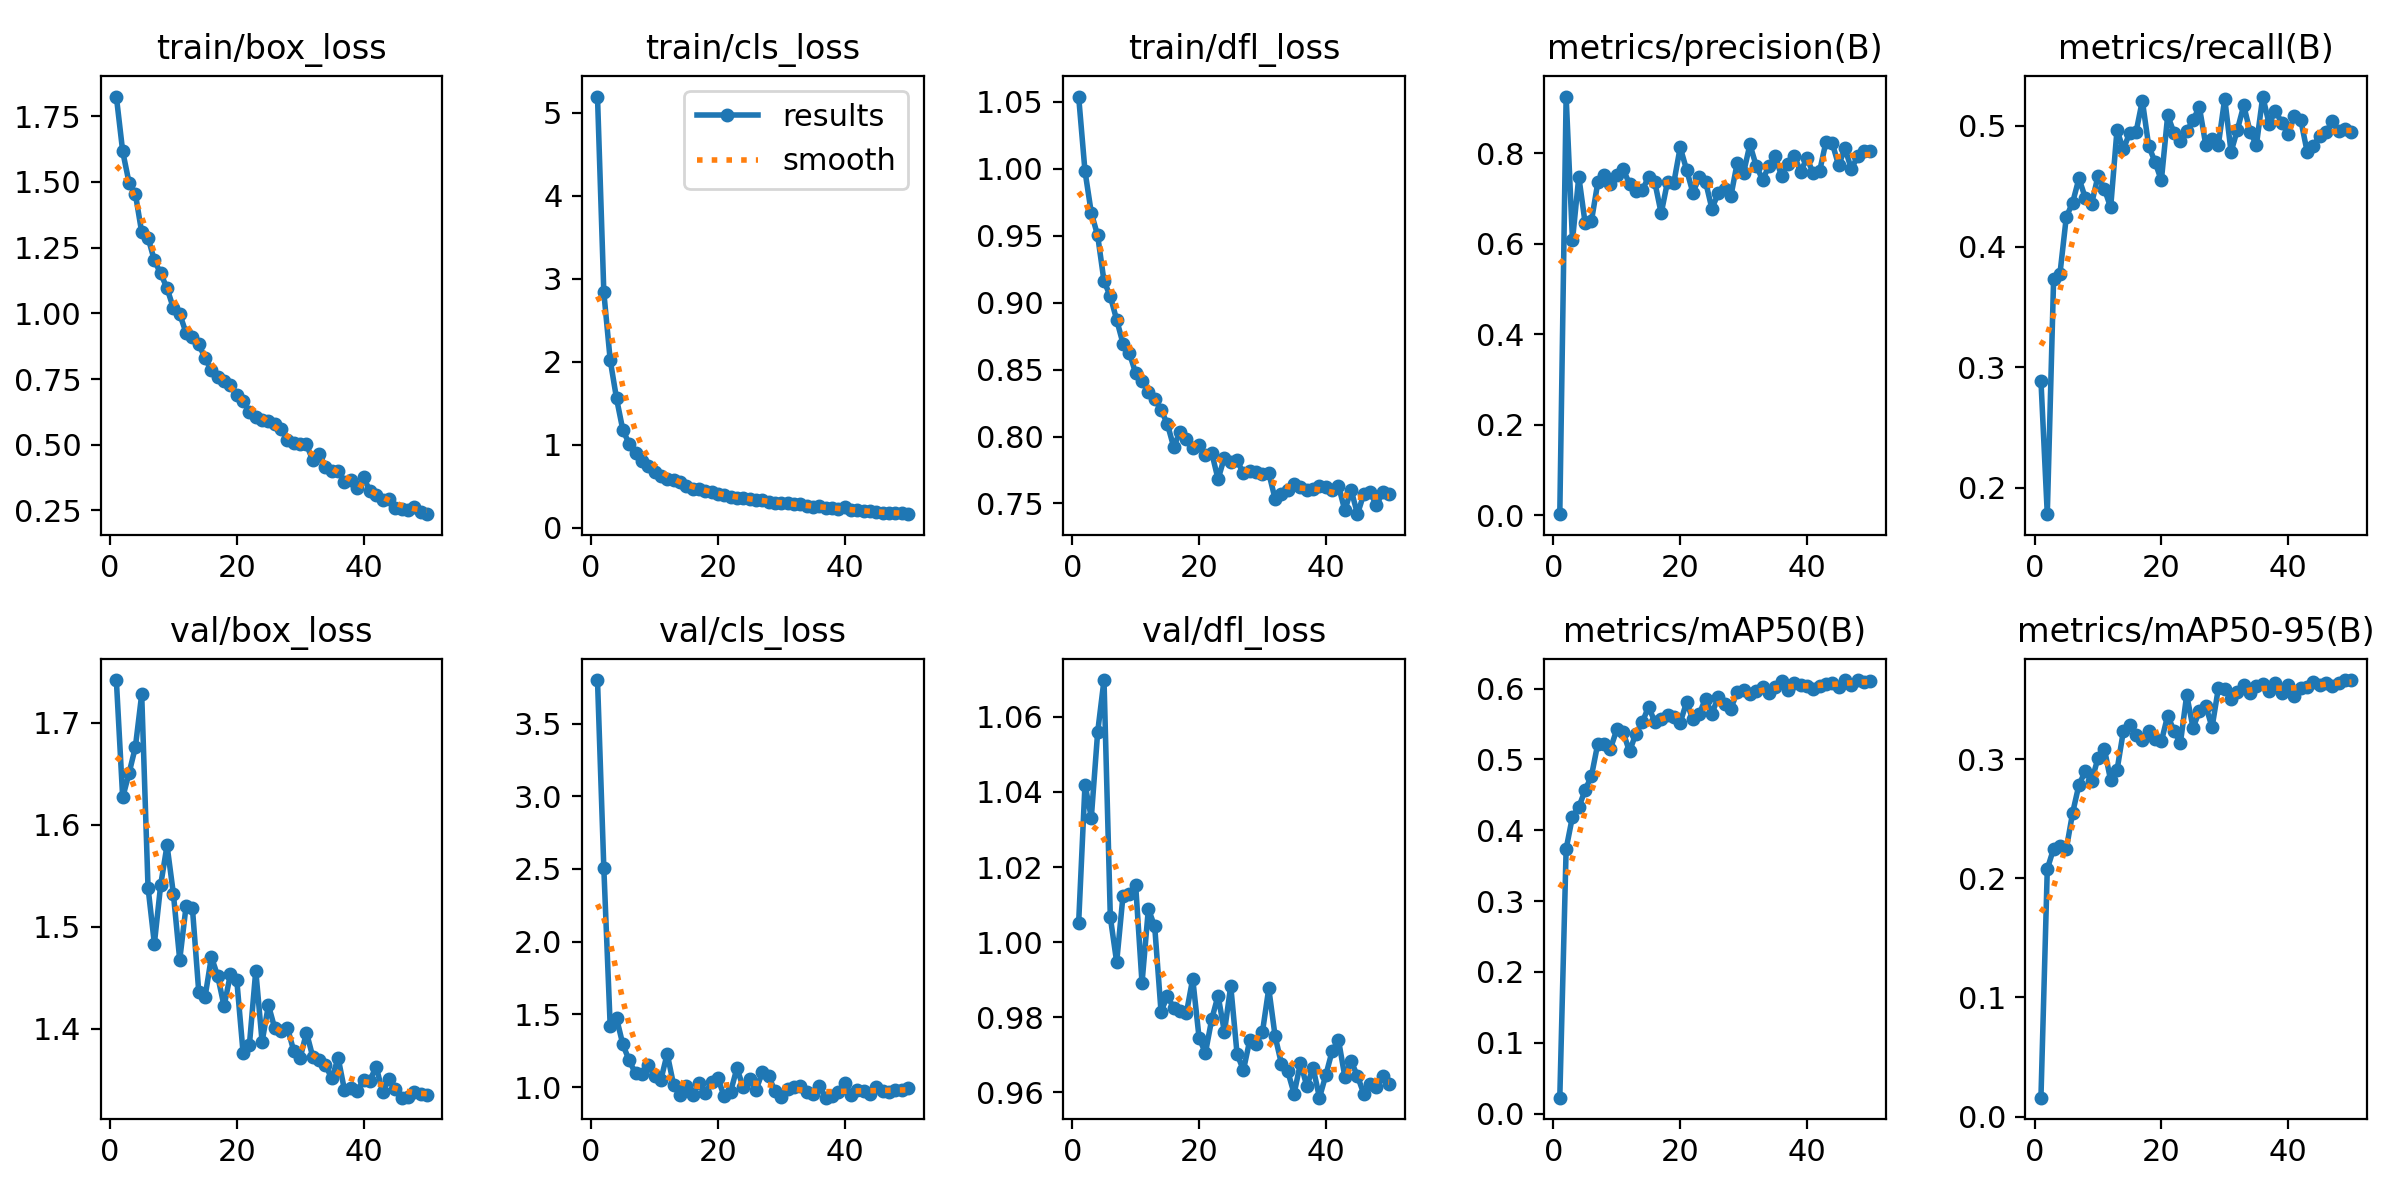


Precision-Recall Curve:


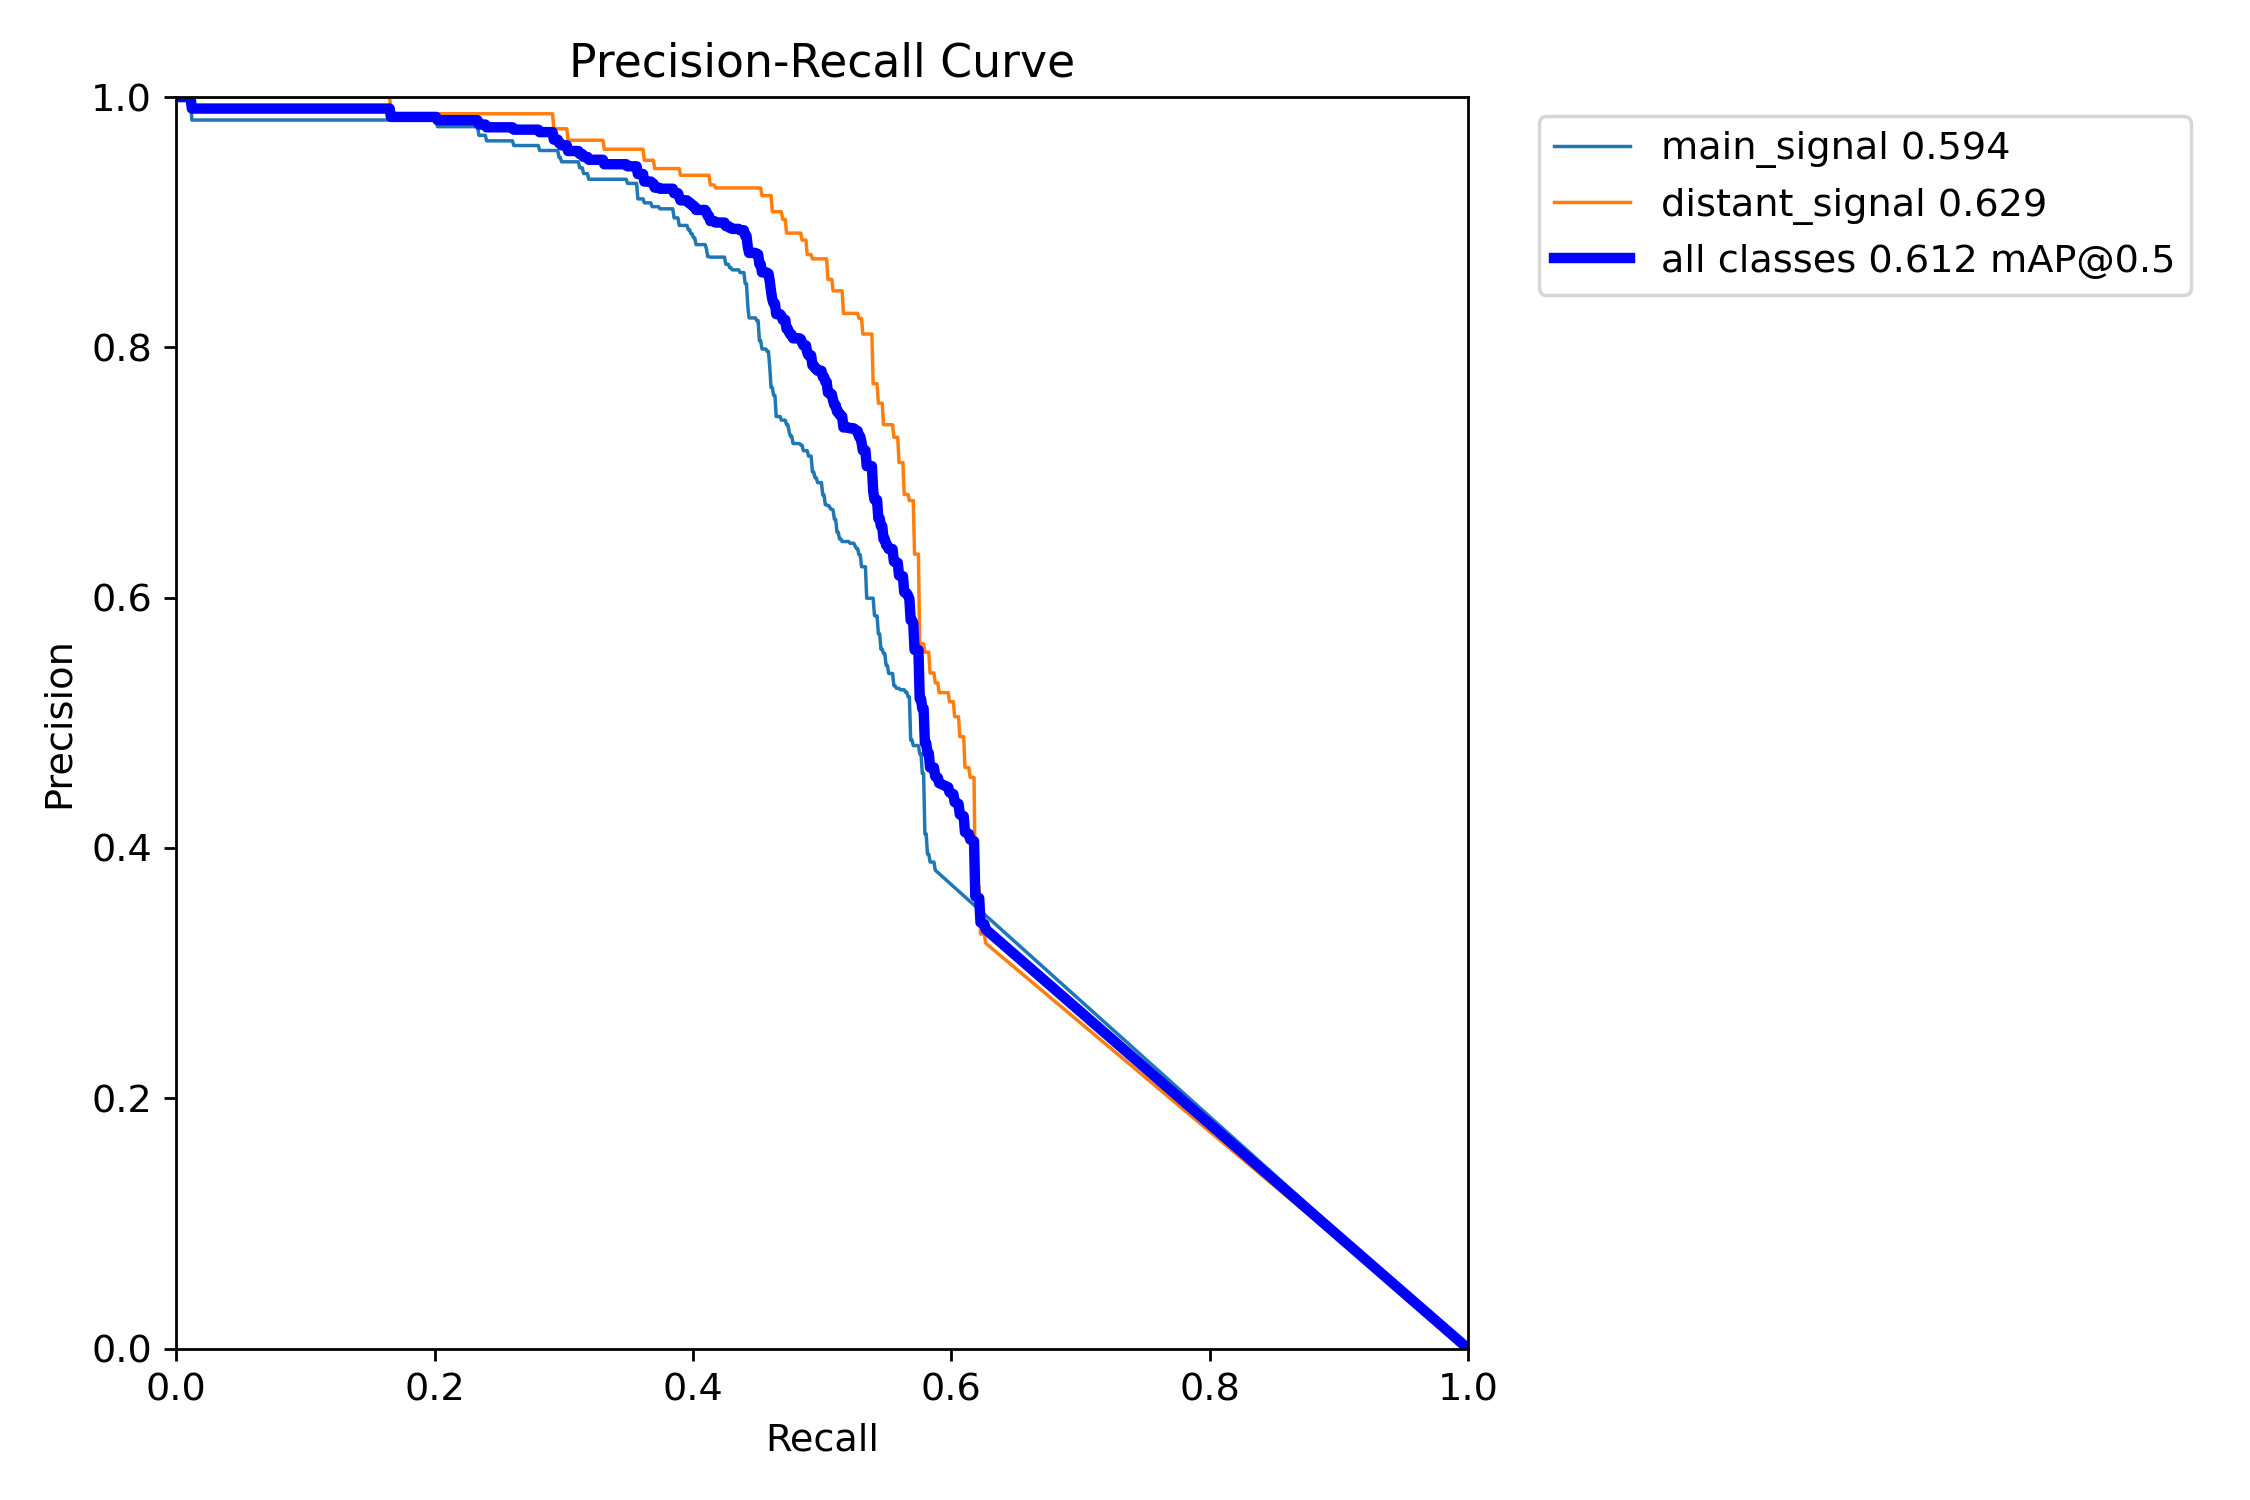


F1 Curve:


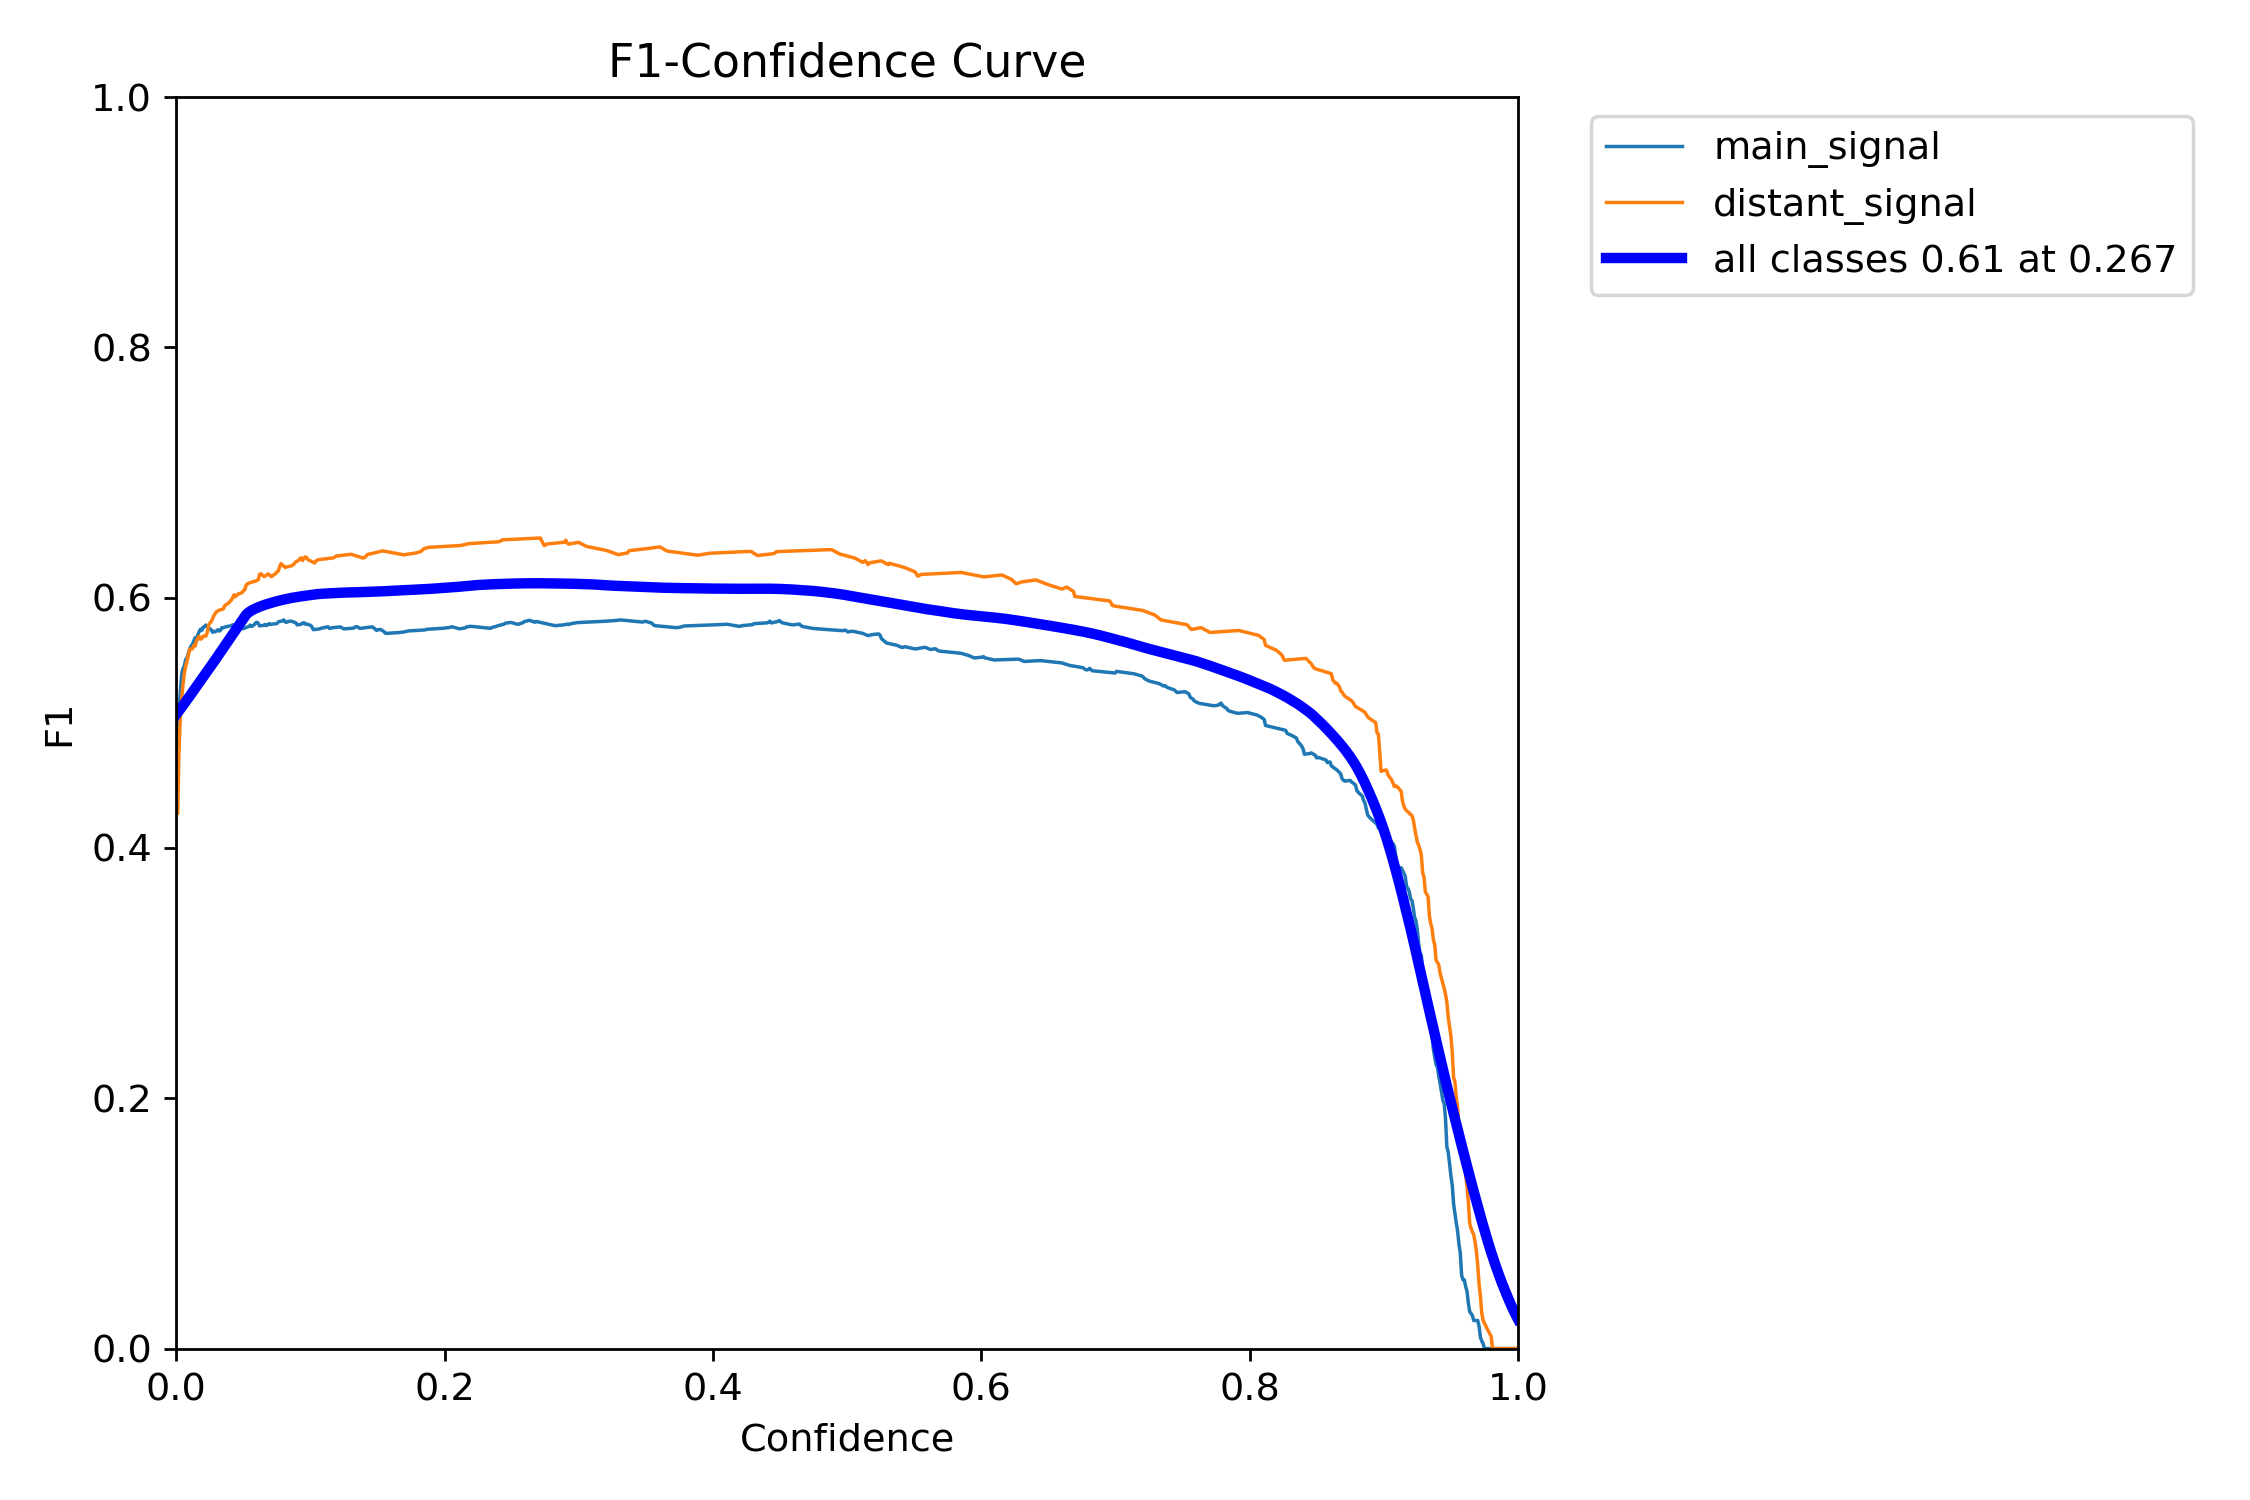


Confusion Matrix (Baseline):


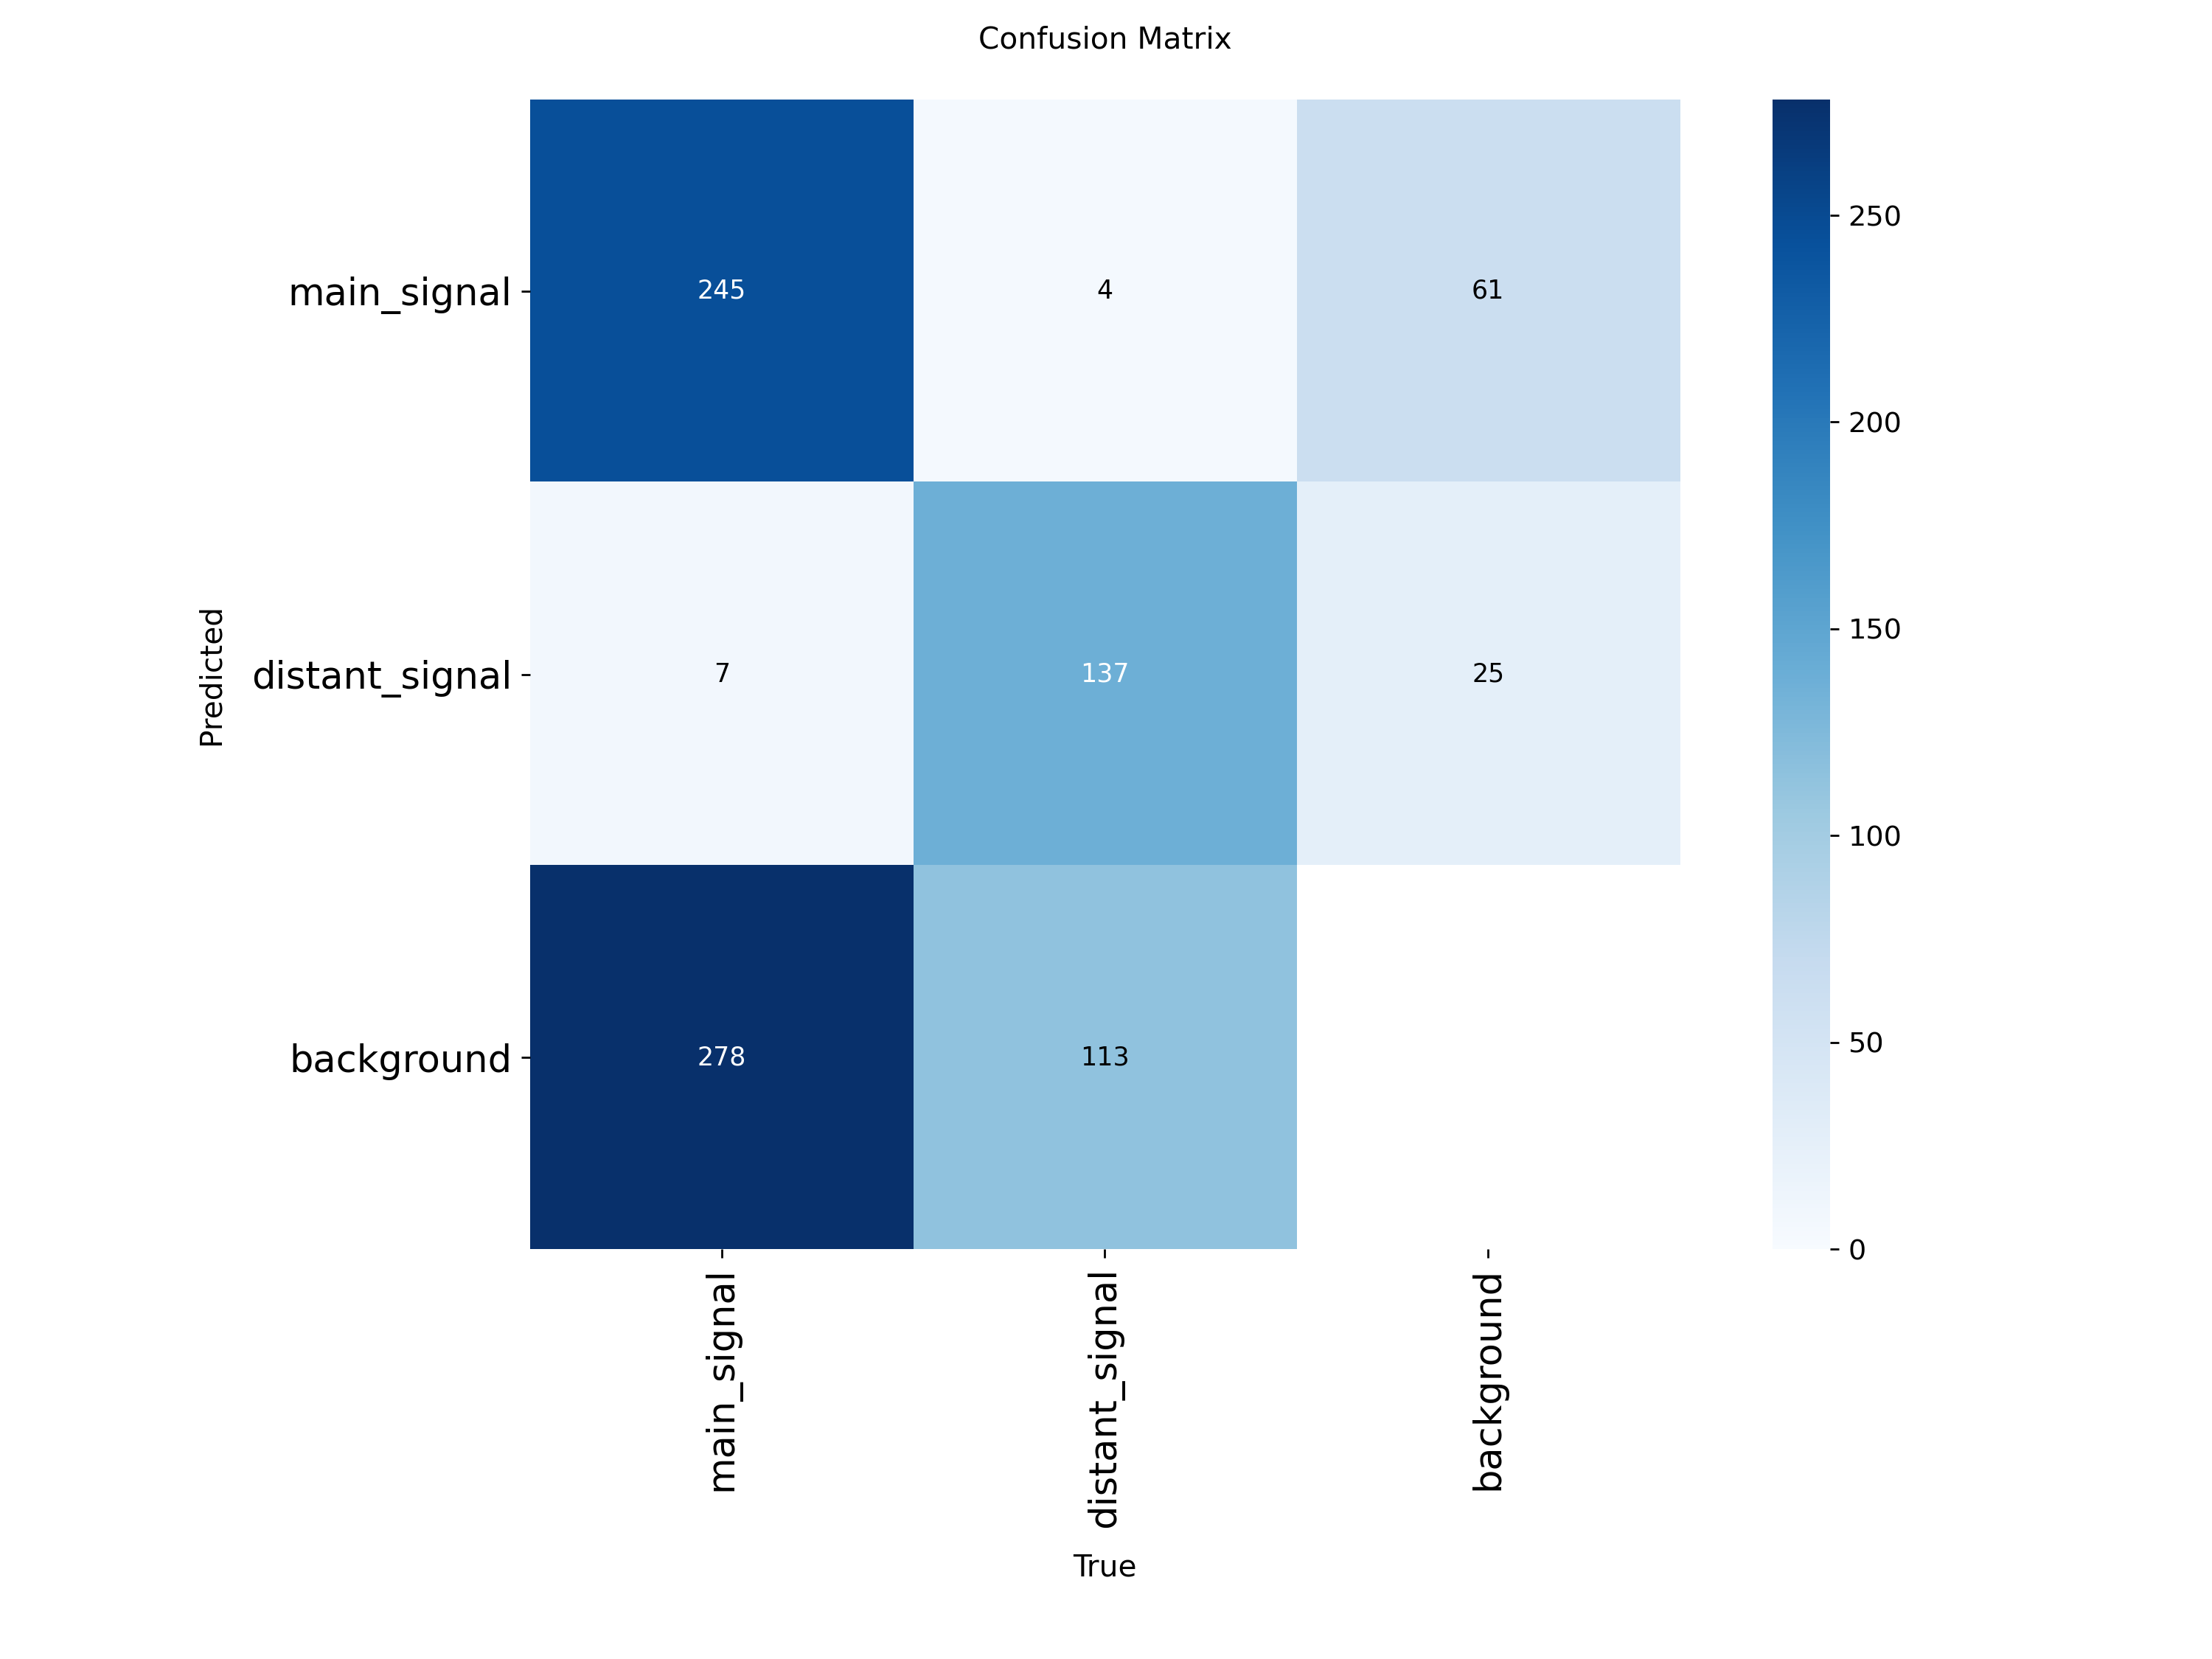

In [14]:
#Display Baseline Training Curves

from IPython.display import Image, display

run_name = "signal_baseline_no_aug"

print("Training Results (Baseline):")
display(Image(filename=f"runs/detect/{run_name}/results.png"))

print("\nPrecision-Recall Curve:")
display(Image(filename=f"runs/detect/{run_name}/BoxPR_curve.png"))

print("\nF1 Curve:")
display(Image(filename=f"runs/detect/{run_name}/BoxF1_curve.png"))

print("\nConfusion Matrix (Baseline):")
display(Image(filename=f"runs/detect/{run_name}/confusion_matrix.png"))


In [13]:
import os

run_name = "signal_baseline_no_aug"
path = f"runs/detect/{run_name}"

print("Files in run directory:")
print(os.listdir(path))


Files in run directory:
['val_batch2_labels.jpg', 'train_batch2.jpg', 'args.yaml', 'train_batch2000.jpg', 'confusion_matrix.png', 'labels.jpg', 'results.csv', 'results.png', 'val_batch2_pred.jpg', 'BoxR_curve.png', 'confusion_matrix_normalized.png', 'val_batch1_pred.jpg', 'BoxF1_curve.png', 'train_batch2002.jpg', 'val_batch0_pred.jpg', 'labels', 'BoxPR_curve.png', 'val_batch1_labels.jpg', 'train_batch2001.jpg', 'train_batch1.jpg', 'train_batch0.jpg', 'weights', 'val_batch0_labels.jpg', 'BoxP_curve.png']


In [18]:
# Train Weather-Augmented YOLO Model

from ultralytics import YOLO
import time

start_time_aug = time.time()

model_aug = YOLO("yolov8n.pt")

aug_results = model_aug.train(
    data="/content/GERALD_subset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=32,
    cache=True,
    workers=8,
    patience=15,

    # WEATHER AUGMENTATION
    degrees=15,
    scale=0.5,
    shear=5,
    flipud=0.2,
    fliplr=0.5,
    mixup=0.3,
    mosaic=1.0,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.5,
    name="signal_augmented",
    save_txt=True,
    save_conf=True,
)

elapsed_aug = (time.time() - start_time_aug) / 60
print(f"\nAugmented training completed in {elapsed_aug:.1f} minutes")


Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/GERALD_subset/data.yaml, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.2, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=signal_augmented, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots=

In [19]:
# Per-Weather Evaluation (Augmented Model)

print("Evaluating Augmented Model per Weather Condition!!!!\n")

# Load augmented model
augmented_model = YOLO("/content/runs/detect/signal_augmented/weights/best.pt")

augmented_weather_results = {}

for weather, img_list in weather_image_groups.items():
    if len(img_list) < 5:
        continue

    print(f"  Evaluating {weather} ({len(img_list)} images)...", end=" ")

    # Run inference
    results_list = []
    for img_name in img_list:
        img_path = val_dir / img_name
        if img_path.exists():
            result = augmented_model.predict(
                source=str(img_path),
                save=False,
                verbose=False,
                conf=0.25
            )
            results_list.append(result[0])

    total_detections = sum([len(r.boxes) for r in results_list])
    avg_confidence = sum([r.boxes.conf.mean().item() if len(r.boxes) > 0 else 0
                          for r in results_list]) / len(results_list)

    augmented_weather_results[weather] = {
        'images': len(img_list),
        'total_detections': total_detections,
        'avg_detections_per_image': total_detections / len(img_list),
        'avg_confidence': avg_confidence
    }


print("\n" + "="*70)
print("AUGMENTED MODEL - WEATHER-SPECIFIC PERFORMANCE")
print("="*70)

df_augmented = pd.DataFrame(augmented_weather_results).T
df_augmented = df_augmented.round(3)
print(df_augmented.to_string())

Evaluating Augmented Model per Weather Condition!!!!

  Evaluating Rainy (95 images)...   Evaluating Snowy (34 images)...   Evaluating Unknown (51 images)...   Evaluating Sunny (67 images)...   Evaluating Foggy (33 images)...   Evaluating Cloudy (118 images)... 
AUGMENTED MODEL - WEATHER-SPECIFIC PERFORMANCE
         images  total_detections  avg_detections_per_image  avg_confidence
Rainy      95.0             128.0                     1.347           0.489
Snowy      34.0              53.0                     1.559           0.666
Unknown    51.0              38.0                     0.745           0.260
Sunny      67.0             118.0                     1.761           0.636
Foggy      33.0              39.0                     1.182           0.556
Cloudy    118.0             190.0                     1.610           0.560


Training Results (Augmented):


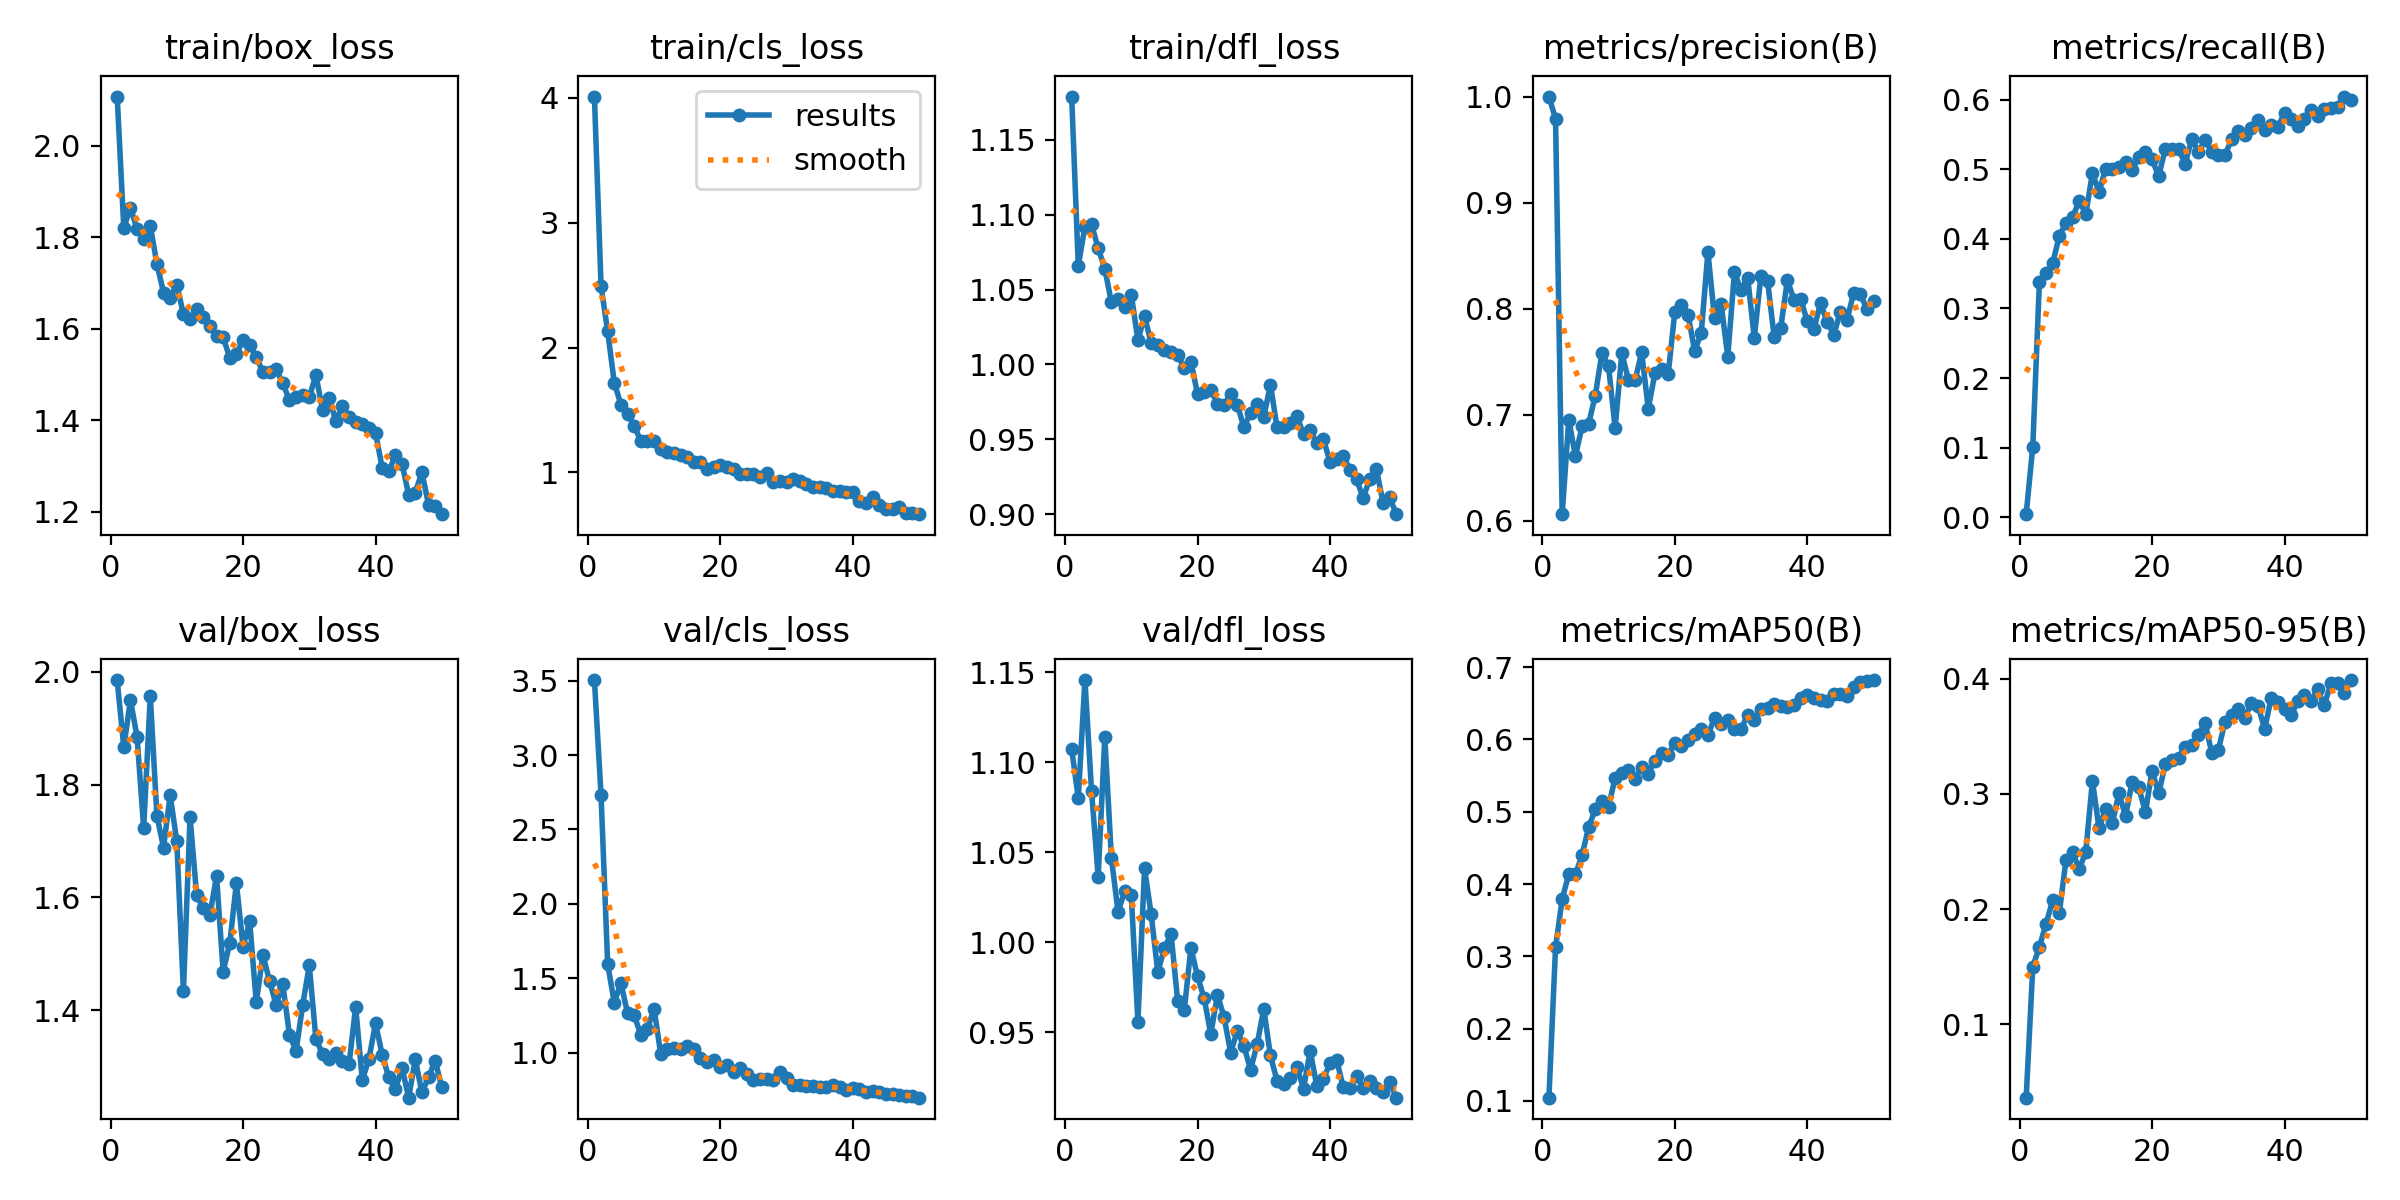


Confusion Matrix (Augmented):


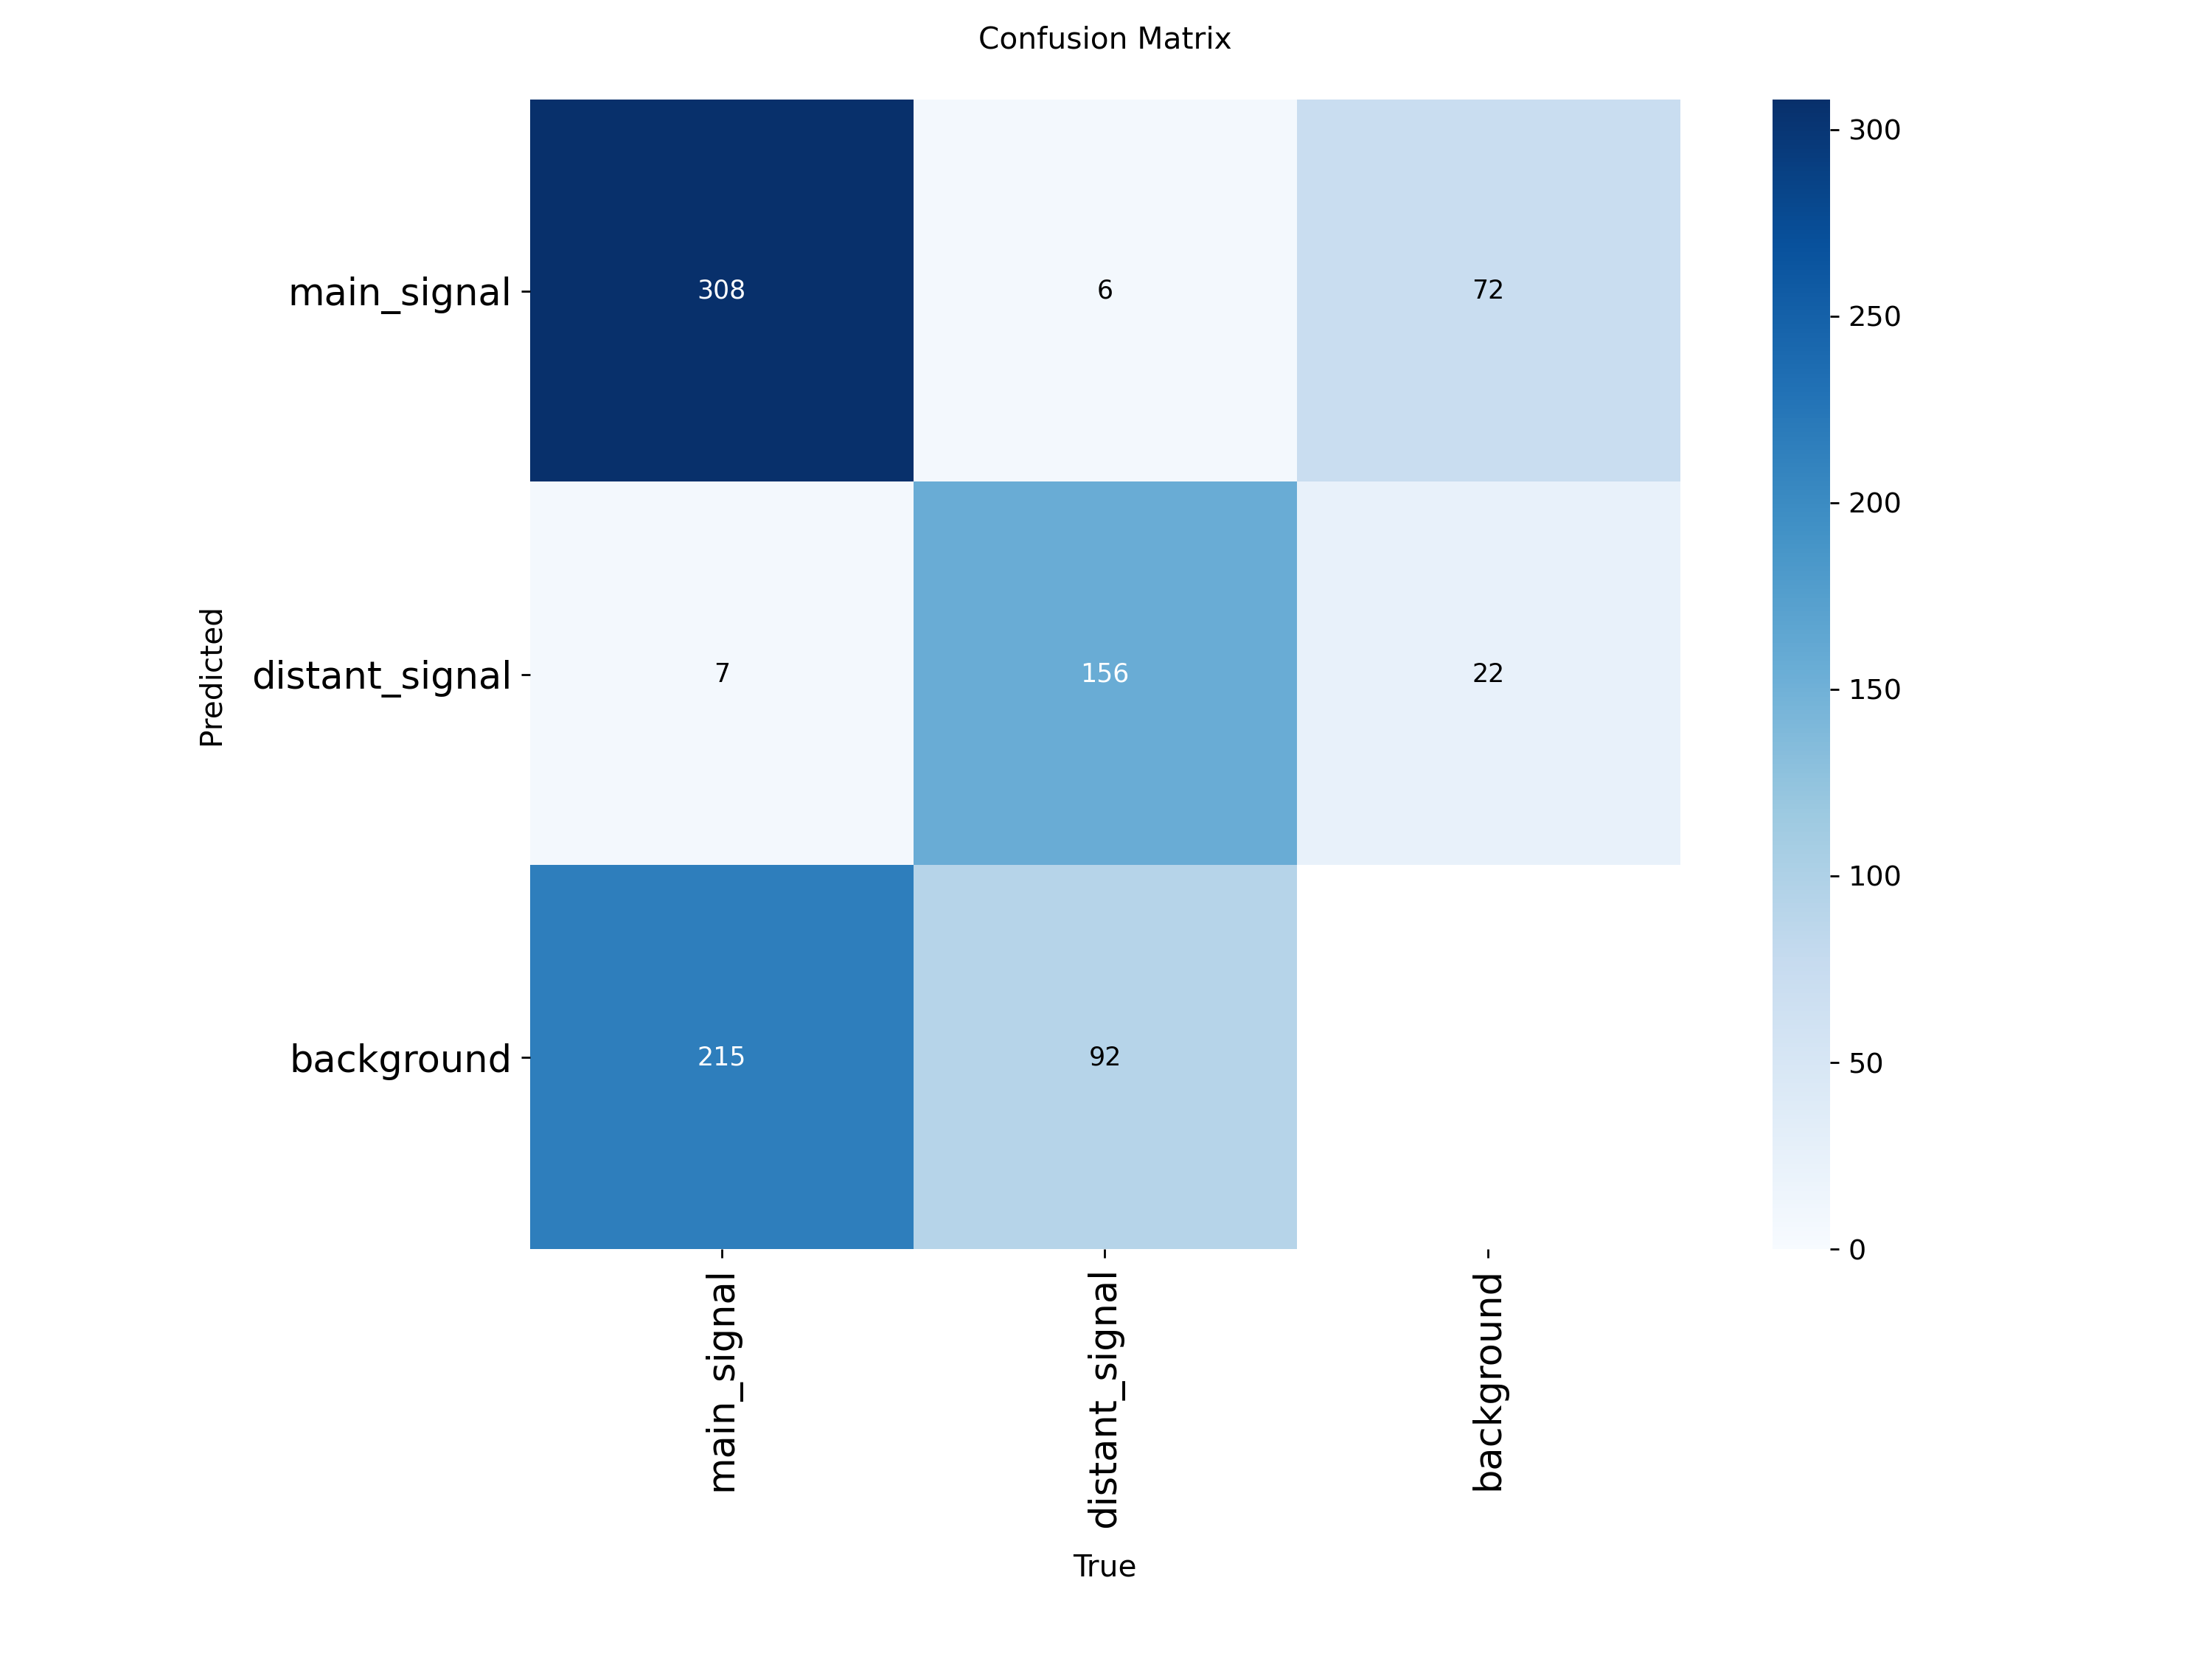

In [20]:
aug_run = "signal_augmented"

print("Training Results (Augmented):")
display(Image(filename=f"runs/detect/{aug_run}/results.png"))

print("\nConfusion Matrix (Augmented):")
display(Image(filename=f"runs/detect/{aug_run}/confusion_matrix.png"))



BASELINE vs AUGMENTED - WEATHER COMPARISON

Average Detections per Image:
Weather         Baseline     Augmented    Improvement 
-------------------------------------------------------
Cloudy          1.20         1.61         +33.8%
Foggy           1.03         1.18         +14.7%
Rainy           1.09         1.35         +23.1%
Snowy           1.65         1.56         -5.4%
Sunny           1.55         1.76         +13.5%
Unknown         0.51         0.75         +46.2%


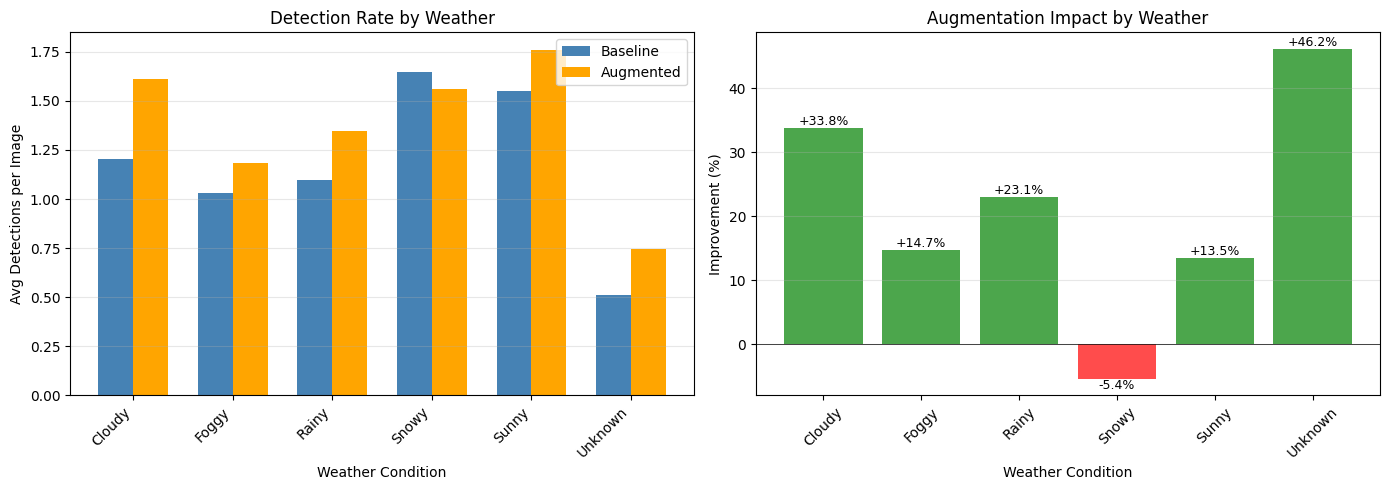


Saved comparison chart: /content/weather_comparison.png

Key Findings:
Biggest improvement: Unknown (+46.2%)
Degradation in: Snowy (-5.4%)
Average improvement: +21.0%


In [21]:
#Comparison Baseline vs Augmented per Weather

import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*70)
print("BASELINE vs AUGMENTED - WEATHER COMPARISON")
print("="*70)

# Prepare comparison data
weather_conditions = sorted(baseline_weather_results.keys())

baseline_detections = [baseline_weather_results[w]['avg_detections_per_image']
                       for w in weather_conditions]
augmented_detections = [augmented_weather_results[w]['avg_detections_per_image']
                        for w in weather_conditions]

baseline_confidence = [baseline_weather_results[w]['avg_confidence']
                       for w in weather_conditions]
augmented_confidence = [augmented_weather_results[w]['avg_confidence']
                        for w in weather_conditions]

# Calculate improvement
improvements = [(aug - base) / base * 100 if base > 0 else 0
                for base, aug in zip(baseline_detections, augmented_detections)]

# Print comparison table
print("\nAverage Detections per Image:")
print(f"{'Weather':<15} {'Baseline':<12} {'Augmented':<12} {'Improvement':<12}")
print("-" * 55)
for i, weather in enumerate(weather_conditions):
    print(f"{weather:<15} {baseline_detections[i]:<12.2f} {augmented_detections[i]:<12.2f} "
          f"{improvements[i]:+.1f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Detections comparison
x = np.arange(len(weather_conditions))
width = 0.35

ax1 = axes[0]
bars1 = ax1.bar(x - width/2, baseline_detections, width, label='Baseline', color='steelblue')
bars2 = ax1.bar(x + width/2, augmented_detections, width, label='Augmented', color='orange')

ax1.set_xlabel('Weather Condition')
ax1.set_ylabel('Avg Detections per Image')
ax1.set_title('Detection Rate by Weather')
ax1.set_xticks(x)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Improvement percentage
ax2 = axes[1]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
bars = ax2.bar(weather_conditions, improvements, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Weather Condition')
ax2.set_ylabel('Improvement (%)')
ax2.set_title('Augmentation Impact by Weather')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:+.1f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=9)

plt.tight_layout()
plt.savefig('/content/weather_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved comparison chart: /content/weather_comparison.png")

# Identify best improvements
print("\nKey Findings:")
best_improvement_idx = np.argmax(improvements)
print(f"Biggest improvement: {weather_conditions[best_improvement_idx]} "
      f"({improvements[best_improvement_idx]:+.1f}%)")

worst_improvement_idx = np.argmin(improvements)
if improvements[worst_improvement_idx] < 0:
    print(f"Degradation in: {weather_conditions[worst_improvement_idx]} "
          f"({improvements[worst_improvement_idx]:+.1f}%)")

avg_improvement = np.mean(improvements)
print(f"Average improvement: {avg_improvement:+.1f}%")

In [23]:
# WEATHER-ADAPTIVE CONFIDENCE THRESHOLD OPTIMIZATION (WACT)
from ultralytics import YOLO
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
from statistics import mean

print("\nRunning Weather-Adaptive Confidence Threshold Optimization!!!\n")

# Load both models
baseline_model = YOLO("/content/runs/detect/signal_baseline_no_aug/weights/best.pt")
aug_model = YOLO("/content/runs/detect/signal_augmented/weights/best.pt")

dataset_root = Path("/content/GERALD_subset")
ann_dir = dataset_root / "annotations"
val_dir = dataset_root / "val" / "images"

# Get validation images grouped by weather condition
weather_groups = defaultdict(list)
val_imgs = {img.name for img in val_dir.glob("*.jpg")}

for xml_file in ann_dir.glob("*.xml"):
    try:
        root = ET.parse(xml_file).getroot()
        img_name = root.find("filename").text
        if img_name in val_imgs:
            weather = root.find("metadata").find("weather").text
            weather_groups[weather].append(img_name)
    except:
        continue

# Evaluate this range of confidence thresholds
thresholds = np.arange(0.10, 0.90, 0.05)

def evaluate_model(model, weather_groups):
    """
    For a given YOLO model, compute optimal confidence threshold per weather condition.
    """
    results = {}

    for weather, img_list in weather_groups.items():
        if len(img_list) < 5:
            continue

        weather_stats = []

        for conf_t in thresholds:
            all_precisions = []
            all_recalls = []

            for img_name in img_list:
                img_path = val_dir / img_name
                if not img_path.exists():
                    continue

                pred = model.predict(source=str(img_path), conf=conf_t, verbose=False)
                det = pred[0].boxes

                # ground truth count
                xml_path = ann_dir / (img_name.replace(".jpg", ".xml"))
                try:
                    root = ET.parse(xml_path).getroot()
                    gt_count = len(root.findall("object"))
                except:
                    gt_count = 0

                pred_count = len(det)

                precision = pred_count / (pred_count + max(gt_count - pred_count, 1))
                recall = pred_count / (gt_count + 1e-6)

                all_precisions.append(precision)
                all_recalls.append(recall)

            avg_precision = mean(all_precisions)
            avg_recall = mean(all_recalls)
            f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-6)

            weather_stats.append((conf_t, avg_precision, avg_recall, f1))

        # Pick the threshold with the best F1 score
        opt_thr, opt_p, opt_r, opt_f1 = max(weather_stats, key=lambda x: x[3])

        results[weather] = {
            "optimal_threshold": round(opt_thr, 3),
            "precision_at_opt": round(opt_p, 3),
            "recall_at_opt": round(opt_r, 3),
            "f1_at_opt": round(opt_f1, 3),
            "samples": len(img_list)
        }

    return pd.DataFrame(results).T


# Apply WACT to both models
print("Optimizing thresholds for Baseline Model!!!!")
df_baseline_wact = evaluate_model(baseline_model, weather_groups)

print("\nOptimizing thresholds for Augmented Model!!!!")
df_aug_wact = evaluate_model(aug_model, weather_groups)

print("\n" + "="*70)
print("WEATHER-ADAPTIVE CONFIDENCE OPTIMIZATION RESULTS")
print("="*70)

print("\n--- Baseline Model ---")
print(df_baseline_wact.to_string())

print("\n--- Augmented Model ---")
print(df_aug_wact.to_string())

print("\nInterpretation:")
print("Lower optimal thresholds in bad weather -> the model needs weaker confidence to detect signals.")
print("Higher thresholds in good weather -> model is more confident and reliable.")



Running Weather-Adaptive Confidence Threshold Optimization!!!

Optimizing thresholds for Baseline Model!!!!

Optimizing thresholds for Augmented Model!!!!

WEATHER-ADAPTIVE CONFIDENCE OPTIMIZATION RESULTS

--- Baseline Model ---
         optimal_threshold  precision_at_opt  recall_at_opt  f1_at_opt  samples
Rainy                  0.1             0.418          0.722      0.530     95.0
Snowy                  0.1             0.585          1.132      0.771     34.0
Unknown                0.1             0.286          0.454      0.351     51.0
Sunny                  0.1             0.516          0.935      0.665     67.0
Foggy                  0.1             0.448          0.977      0.615     33.0
Cloudy                 0.1             0.466          0.746      0.574    118.0

--- Augmented Model ---
         optimal_threshold  precision_at_opt  recall_at_opt  f1_at_opt  samples
Rainy                  0.1             0.539          1.018      0.705     95.0
Snowy                  0.

In [ ]:
!cp /content/runs/detect/signal_baseline/weights/best.pt /content/drive/MyDrive/



image 1/1 /content/GERALD_subset/images/Rheydt-Aachen.mp4#t=4373.766667.jpg: 384x640 1 distant_signal, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


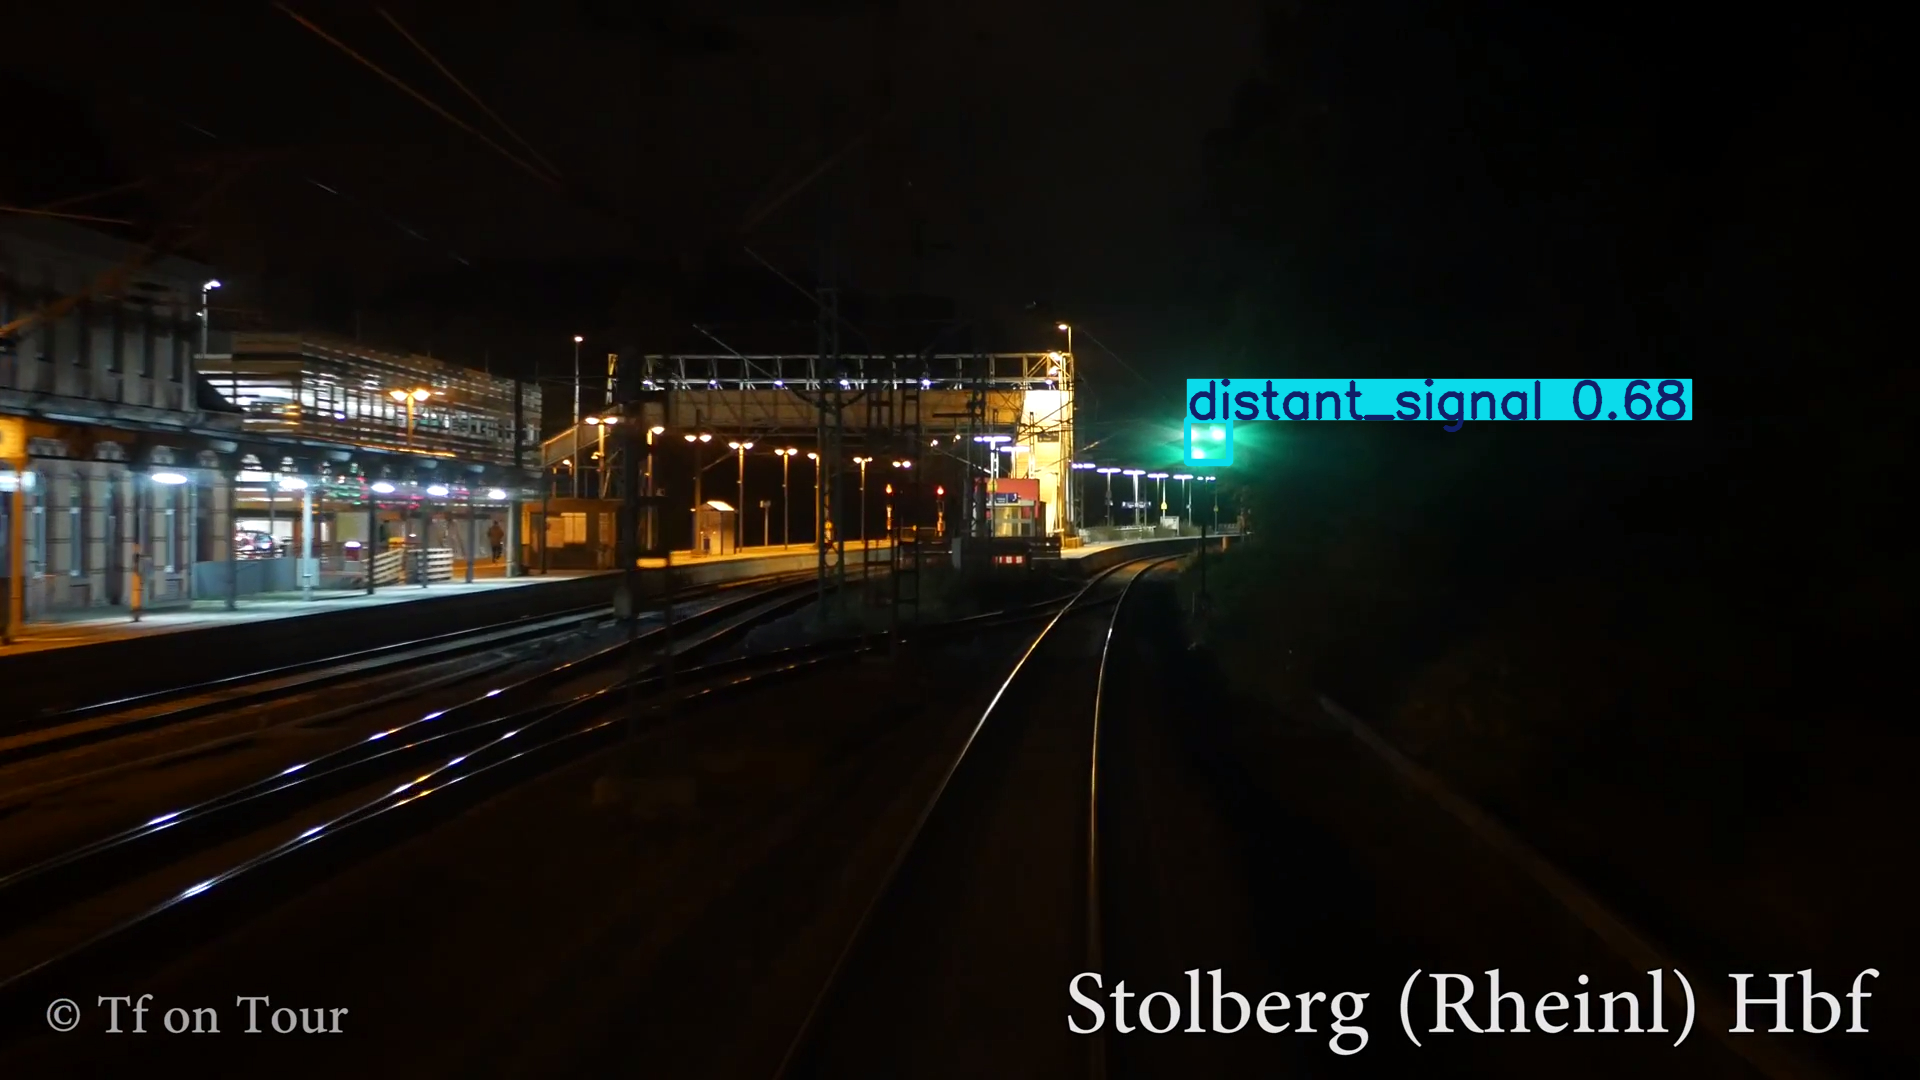

In [24]:
from ultralytics import YOLO

# load your trained model
model = YOLO("./runs/detect/signal_augmented/weights/best.pt")


# predict on a single image
#results = model("/content/GERALD_subset/images/Fulda-W%C3%BCrzburg.mp4#t=6014.2.jpg")
results = model("/content/GERALD_subset/images/Rheydt-Aachen.mp4#t=4373.766667.jpg")
# show the results for the first (and only) image
results[0].show()  # note the [0]!


In [ ]:
!find . -name "best.pt"




./runs/detect/signal_yolov83/weights/best.pt
